In [1]:
from ogb.lsc import PCQM4Mv2Dataset

import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx
from torch_geometric.datasets import MoleculeNet
import matplotlib.pyplot as plt

import torch
import os
import pandas as pd
import numpy as np
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import torch
import torch.nn as nn

import Data_Preprocessing.Graph_Data as gd
from Data_Preprocessing.Graph_Data import Molecule_data
from models.AttentiveFPModel import AttentiveFP
import seaborn as sns

In [2]:
dataset = PCQM4Mv2Dataset(root = 'pcqm4m-v2-train.sdf', only_smiles = True)

In [3]:
smiles = []
band_gap = []

In [4]:
for item in dataset:
    smiles.append(item[0])
    band_gap.append(item[1])

In [5]:
len(smiles)

3746620

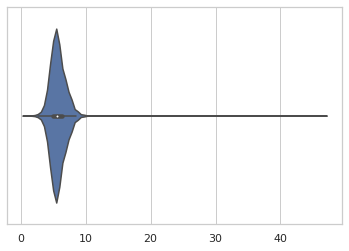

In [6]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.violinplot(x=band_gap)

In [7]:
smile_graph = {}
band_gap_arr = []
smiles_array = []

# for i,smile in tqdm(enumerate(smiles)):
#     if i > 10000:
#         break
#     if len(smile) > 1:
#         g = gd.smile_to_graph(smile)
#         if g != None:
#             smile_graph[smile] = g
#             band_gap_arr.append(band_gap[i])
#             smiles_array.append(smile)
    

In [8]:
#sm = smiles_array[85975]

In [9]:
#sm

In [10]:
banch_data = Molecule_data(root='data', dataset='banchmark_data_set',y=band_gap_arr,smile_graph=smile_graph,smiles=smiles_array)

In [11]:
TRAIN_BATCH_SIZE = 17
banch_loder   = DataLoader(banch_data,batch_size=TRAIN_BATCH_SIZE,shuffle=True)

In [12]:
if torch.cuda.is_available():  
    device = "cuda:1"
    print("cuda:1")
else:  
    device = "cpu" 
    print(torch.cuda.is_available())

cuda:1


In [13]:
def predicting(model, device, loader,loss_fn):
    model.eval()
    total_loss=total_example=0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data.x.float(), data.edge_index,data.batch)
            loss = loss_fn(output, data.y.view(-1, 1).float().to(device))
            total_loss+=loss
            total_example+=1
    return total_loss/total_example

In [14]:
model = AttentiveFP(in_channels=114, hidden_channels=292, out_channels=1,
                    num_layers=3, num_timesteps=1,
                    dropout= 0.05115077176824934).to(device)

In [15]:
model_file_name = 'Graph_attention_best_12.model'
model.load_state_dict(torch.load(model_file_name))

<All keys matched successfully>

In [16]:
y_pred_arr = []
target_array = []
for data in banch_loder:
    data = data.to(device)
    y_pred = model(data.x.float(), data.edge_index,data.batch)
    #y_pred = model(data)
    y_pred_arr.append(y_pred)
    target_array.append(data.y.float())

In [17]:
y_ped=torch.cat(y_pred_arr).view(-1).cpu().detach().numpy()
y_true=torch.cat(target_array).cpu().detach().numpy()

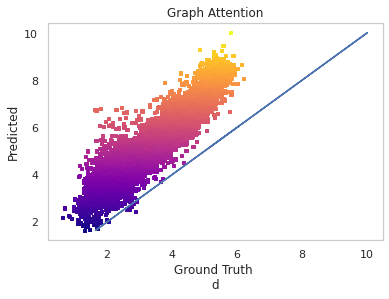

In [24]:
plt.scatter(y_ped,y_true,s=10,marker ="s",c=y_true,cmap=plt.get_cmap('plasma'))
plt.plot(y_true,y_true)
plt.xlabel('Ground Truth \nd')
plt.ylabel('Predicted')
plt.title('Graph Attention')
plt.grid(False)
plt.savefig('Graph_attention_banchmark.png', dpi=400,transparent=True)
plt.show()

In [19]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import math

In [20]:
MSE = mean_squared_error(y_true, y_ped)
print(MSE)

4.113469


In [21]:
print(mean_absolute_error(y_true,y_ped))

1.9608629


In [22]:
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

2.0281689091001103
